In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [2]:
# Load the dataset
try:
    df = pd.read_csv('exchange_rate.csv')
    print("Dataset loaded successfully.")
    print("Initial 5 rows:")
    print(df.head())
    print("\nDataset Info:")
    print(df.info())
except FileNotFoundError:
    print("Error: exchange_rate.csv not found. Please ensure the file is in the correct directory.")
    exit()

Dataset loaded successfully.
Initial 5 rows:
               date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB
None


In [3]:
# Parse the date column
# Assuming the first column is the date and the second is 'USD to Australian Dollar'
# Let's inspect the column names to be sure
print("\nColumn names:", df.columns)


Column names: Index(['date', 'Ex_rate'], dtype='object')


In [4]:

# Assuming the first column is 'Date' or similar and the second is the target currency
# We will use iloc for robust column selection based on description
date_column_name = df.columns[0]
currency_column_name = df.columns[1] # USD to Australian Dollar

In [7]:
df[date_column_name] = pd.to_datetime(df[date_column_name], format='%d-%m-%Y %H:%M')
df.set_index(date_column_name, inplace=True)

In [8]:
# Rename the currency column for clarity
df.rename(columns={currency_column_name: 'USD_AUD'}, inplace=True)


In [9]:
# Select only the target currency column for time series analysis
ts_data = df['USD_AUD'].copy()

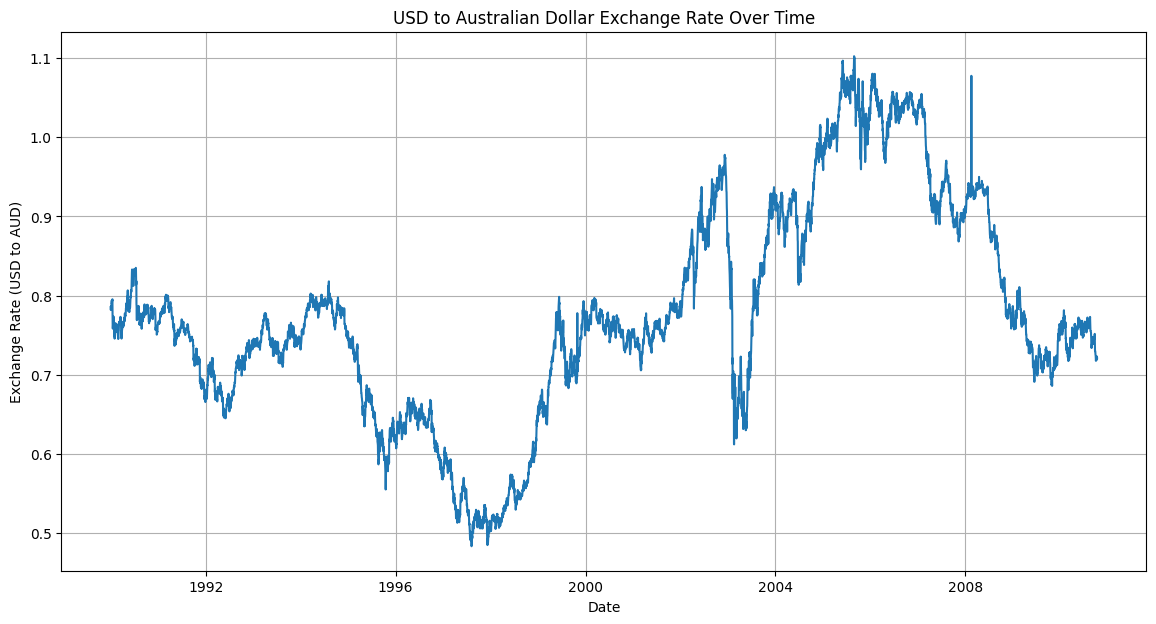

In [10]:
# Initial Exploration: Plot the time series
plt.figure(figsize=(14, 7))
plt.plot(ts_data)
plt.title('USD to Australian Dollar Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.grid(True)
plt.show()

In [11]:

# Data Preprocessing: Handle any missing values or anomalies
print("\nChecking for missing values:")
print(ts_data.isnull().sum())


Checking for missing values:
0


In [12]:

# If there are missing values, a common strategy is to forward-fill or interpolate
if ts_data.isnull().sum() > 0:
    ts_data.fillna(method='ffill', inplace=True)
    print("Missing values handled using forward fill.")
    # Or, if interpolation is more suitable for your data:
    # ts_data.interpolate(method='time', inplace=True)
    # print("Missing values handled using time-based interpolation.")

In [13]:

# Check for anomalies (e.g., extreme outliers) - visual inspection from plot is key,
# but we can also look at basic statistics
print("\nDescriptive Statistics of Exchange Rate:")
print(ts_data.describe())


Descriptive Statistics of Exchange Rate:
count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: USD_AUD, dtype: float64


In [14]:
# A simple check for zero or negative values if rates are expected to be positive
if (ts_data <= 0).any():
    print("Warning: Zero or negative exchange rates found. Investigate data quality.")

In [15]:
# To ensure stationarity, we often need to difference the series.
# Let's perform a first-order differencing and visualize.
ts_data_diff = ts_data.diff().dropna()

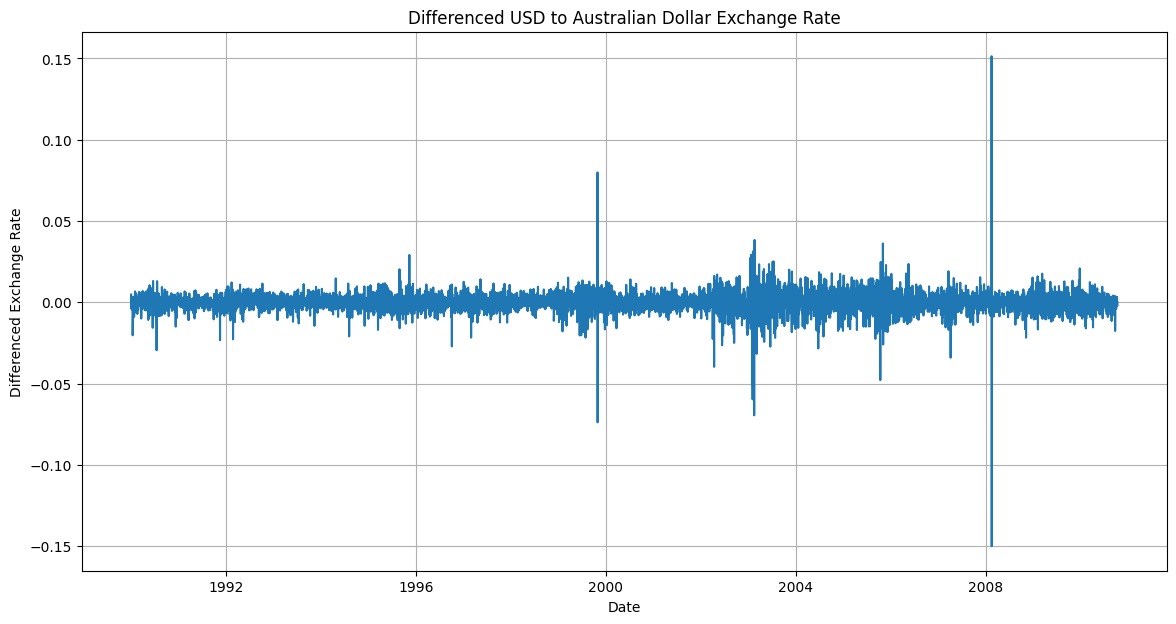

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(ts_data_diff)
plt.title('Differenced USD to Australian Dollar Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Differenced Exchange Rate')
plt.grid(True)
plt.show()

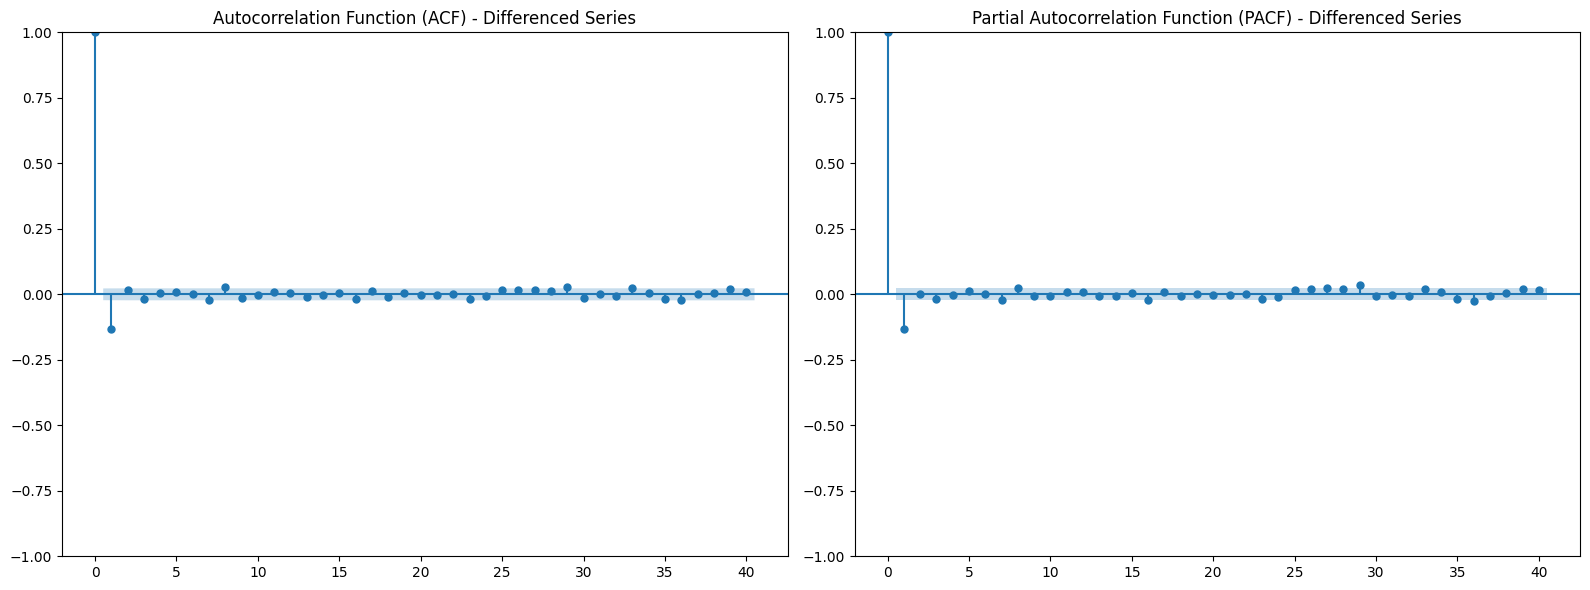

In [18]:
# Parameter Selection for ARIMA: Utilize ACF and PACF plots
# These plots help in determining the p (AR order) and q (MA order) parameters.
# 'd' (differencing order) is often determined by the number of differences needed to make the series stationary.
# Based on the plot of the differenced series, we might start with d=1.

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(ts_data_diff, ax=axes[0], lags=40)
axes[0].set_title('Autocorrelation Function (ACF) - Differenced Series')

plot_pacf(ts_data_diff, ax=axes[1], lags=40, method='ywm') # Added method='ywm' to avoid UserWarning
axes[1].set_title('Partial Autocorrelation Function (PACF) - Differenced Series')

plt.tight_layout()
plt.show()

In [19]:
# Based on ACF and PACF plots, estimate initial p, d, q values.
# Interpretation guidelines:
# - PACF: Sharp drop-off after k lags suggests AR(k) process. p is the order.
# - ACF: Sharp drop-off after k lags suggests MA(k) process. q is the order.
# - If both tail off, it might be an ARMA process.
# - 'd' is the number of differences needed for stationarity (often 0, 1, or 2).
# For exchange rates, d=1 is a common starting point.
print("\nInterpreting ACF and PACF plots:")
print("Look for the point where the plots drop significantly to zero or within the confidence intervals.")
print("For example, if PACF cuts off after lag 1, consider p=1.")
print("If ACF cuts off after lag 1, consider q=1.")
print("A common starting point for non-seasonal financial data is ARIMA(1,1,1) or similar variations.")


Interpreting ACF and PACF plots:
Look for the point where the plots drop significantly to zero or within the confidence intervals.
For example, if PACF cuts off after lag 1, consider p=1.
If ACF cuts off after lag 1, consider q=1.
A common starting point for non-seasonal financial data is ARIMA(1,1,1) or similar variations.


In [20]:
# Split data into training and testing sets
train_size = int(len(ts_data) * 0.8)
train_data, test_data = ts_data[0:train_size], ts_data[train_size:]

print(f"\nTraining data points: {len(train_data)}")
print(f"Test data points: {len(test_data)}")


Training data points: 6070
Test data points: 1518


In [21]:
# Model Fitting: Fit the ARIMA model with selected parameters
# Let's start with a common assumption for financial data: ARIMA(1,1,1)
# Adjust p, d, q based on your ACF/PACF interpretations.
order = (1, 1, 1) # Example order, adjust based on your analysis

print(f"\nFitting ARIMA model with order {order}...")
try:
    arima_model = ARIMA(train_data, order=order)
    arima_fit = arima_model.fit()
    print("ARIMA Model Summary:")
    print(arima_fit.summary())
except Exception as e:
    print(f"Error fitting ARIMA model: {e}")
    print("Consider trying different (p,d,q) values if the model fails to converge or fit.")



Fitting ARIMA model with order (1, 1, 1)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Mon, 21 Jul 2025   AIC                         -45432.092
Time:                        11:20:18   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-0


ARIMA Model Residuals Analysis:


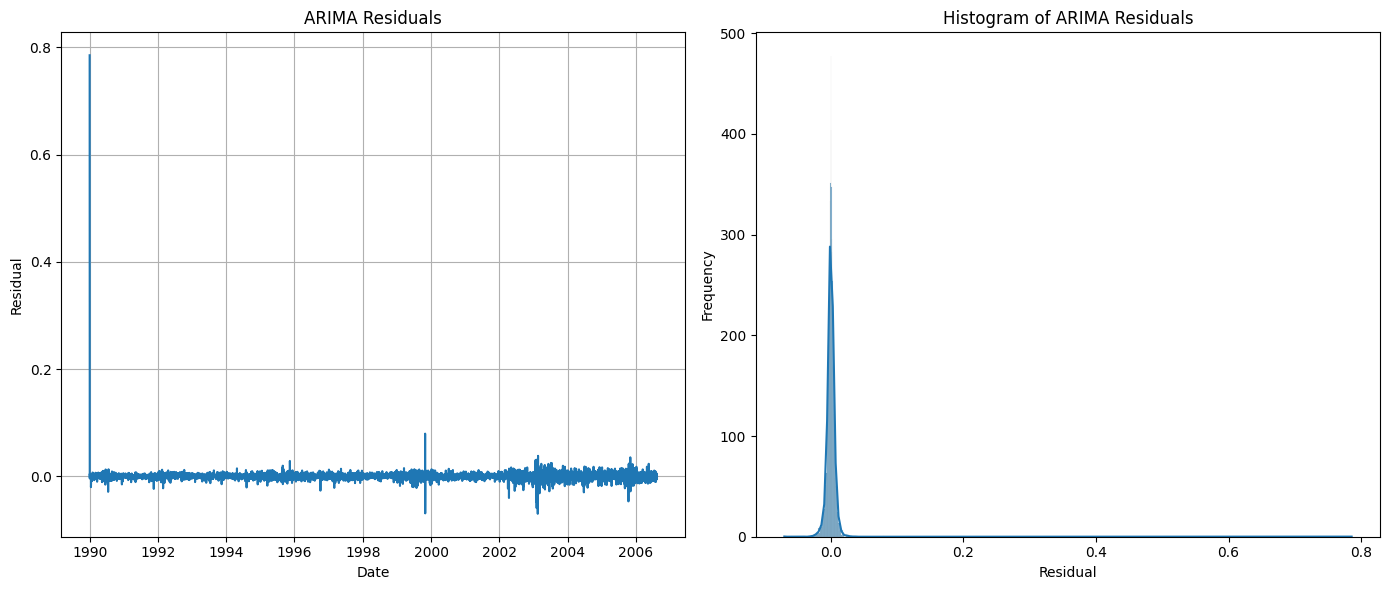

Residuals Mean: 0.0001701004449095851
Residuals Standard Deviation: 0.011595102923146852

Ljung-Box Test for ARIMA Residuals (lag=10):
     lb_stat  lb_pvalue
10  1.647217   0.998399

ARIMA Forecast (first 5 values):
2006-08-15    1.023685
2006-08-16    1.023606
2006-08-17    1.023653
2006-08-18    1.023625
2006-08-19    1.023642
Freq: D, Name: predicted_mean, dtype: float64


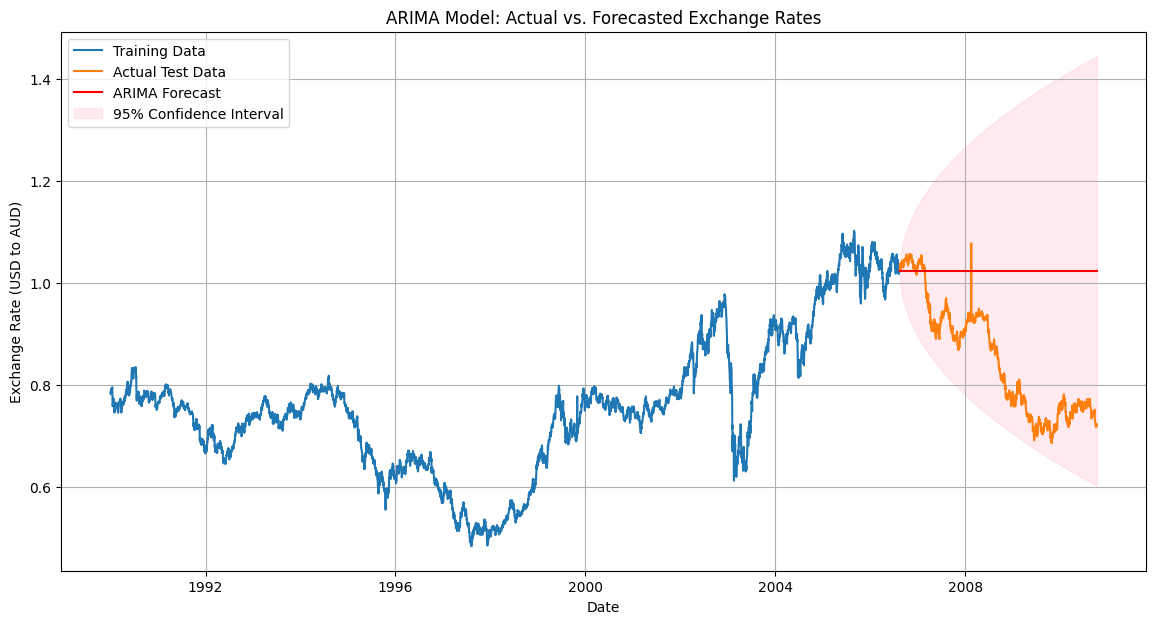

In [22]:
# Diagnostics: Analyze the residuals
if 'arima_fit' in locals():
    print("\nARIMA Model Residuals Analysis:")
    residuals = arima_fit.resid
    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    plt.plot(residuals)
    plt.title('ARIMA Residuals')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.grid(True)

    plt.subplot(122)
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of ARIMA Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Check for normality and autocorrelation in residuals
    print("Residuals Mean:", residuals.mean())
    print("Residuals Standard Deviation:", residuals.std())

    # Ljung-Box test for autocorrelation in residuals
    # p-value > 0.05 suggests no significant autocorrelation
    from statsmodels.stats.diagnostic import acorr_ljungbox
    ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("\nLjung-Box Test for ARIMA Residuals (lag=10):")
    print(ljung_box_test)

    # Forecasting
    # Determine the number of steps to forecast (length of test data)
    n_forecast_steps = len(test_data)
    arima_forecast_index = test_data.index

    # Get forecasts
    arima_forecast = arima_fit.get_forecast(steps=n_forecast_steps)
    arima_predictions = arima_forecast.predicted_mean
    arima_conf_int = arima_forecast.conf_int()

    print("\nARIMA Forecast (first 5 values):")
    print(arima_predictions.head())

    # Visualize the predicted values against the actual values
    plt.figure(figsize=(14, 7))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Actual Test Data')
    plt.plot(arima_forecast_index, arima_predictions, label='ARIMA Forecast', color='red')
    plt.fill_between(arima_conf_int.index, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
    plt.title('ARIMA Model: Actual vs. Forecasted Exchange Rates')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (USD to AUD)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("ARIMA model was not fitted successfully, skipping diagnostics and forecasting.")


Building Exponential Smoothing Model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Exponential Smoothing Model Summary (Holt's Linear):
                       ExponentialSmoothing Model Results                       
Dep. Variable:                  USD_AUD   No. Observations:                 6070
Model:             ExponentialSmoothing   SSE                              0.199
Optimized:                         True   AIC                         -62655.663
Trend:                         Additive   BIC                         -62628.819
Seasonal:                          None   AICC                        -62655.650
Seasonal Periods:                  None   Date:                 Mon, 21 Jul 2025
Box-Cox:                          False   Time:                         11:21:46
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9428890                alpha   

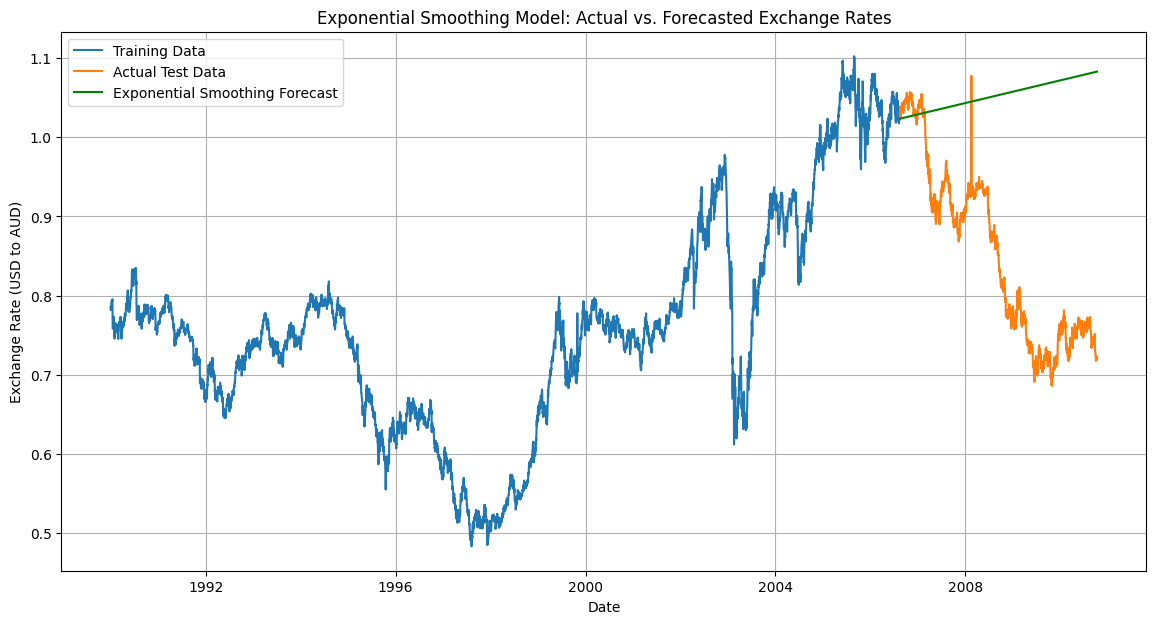

In [23]:
# Model Selection for Exponential Smoothing
# Given that exchange rates might not have strong seasonality,
# Holt's Linear method (for trend) or Simple Exponential Smoothing (for no trend/seasonality)
# are good starting points. If seasonality is suspected, Holt-Winters would be appropriate.
# For this dataset, let's start with a general Exponential Smoothing model and let it optimize.

print("\nBuilding Exponential Smoothing Model...")

# Exponential Smoothing model fitting and forecasting
# We will use the same train/test split as for ARIMA
# The 'seasonal_periods' argument should be set if seasonality is observed (e.g., 12 for monthly, 7 for weekly)
# Since strong seasonality isn't typically expected for daily exchange rates, we might not include it initially
# or set it to a very high value if the data is long enough to capture yearly patterns.
# For simplicity, let's start without explicit seasonality, or try additive/multiplicative trend.

# Let's try an additive trend, as exchange rates can change linearly.
# Setting initialization_method to 'estimated' allows the model to estimate initial values.
try:
    # Holt's Linear method (trend only)
    # If there's a trend, this is a good choice.
    exp_smoothing_model = ExponentialSmoothing(train_data, trend='add', seasonal=None,
                                               initialization_method="estimated")
    exp_smoothing_fit = exp_smoothing_model.fit()
    print("Exponential Smoothing Model Summary (Holt's Linear):")
    print(exp_smoothing_fit.summary())

    # Forecasting
    es_forecast_index = test_data.index
    es_predictions = exp_smoothing_fit.forecast(steps=n_forecast_steps) # Use n_forecast_steps from ARIMA

    print("\nExponential Smoothing Forecast (first 5 values):")
    print(es_predictions.head())

    # Visualize the predicted values against the actual values
    plt.figure(figsize=(14, 7))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Actual Test Data')
    plt.plot(es_forecast_index, es_predictions, label='Exponential Smoothing Forecast', color='green')
    plt.title('Exponential Smoothing Model: Actual vs. Forecasted Exchange Rates')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (USD to AUD)')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error fitting Exponential Smoothing model: {e}")
    print("Consider trying different configurations (e.g., trend='mul', seasonal=None).")

# Optional: Trying different Exponential Smoothing models if the first one doesn't perform well.
# For example, Holt-Winters if seasonality is present:
# from statsmodels.tsa.api import ExponentialSmoothing
# exp_smoothing_hw_model = ExponentialSmoothing(train_data, seasonal_periods=some_period, trend='add', seasonal='add')
# exp_smoothing_hw_fit = exp_smoothing_hw_model.fit()

In [24]:
# Compute Error Metrics
# Ensure both models have successfully generated predictions
if 'arima_predictions' in locals() and 'es_predictions' in locals():
    # Align the test data and predictions if their indices are not perfectly aligned
    # This can happen if, for example, the forecasting starts from a slightly different point
    # or if there are gaps in the test_data index that are not handled by forecast.
    # For simplicity, we assume the length and order of test_data and predictions match.

    # Ensure both predictions cover the same period as test_data
    # If the forecast range is slightly different from test_data index,
    # you might need to re-index the predictions or slice test_data
    # For this exercise, we assume direct comparison is valid.
    actual_values = test_data

    # Error Metrics for ARIMA
    mae_arima = mean_absolute_error(actual_values, arima_predictions)
    rmse_arima = np.sqrt(mean_squared_error(actual_values, arima_predictions))
    # MAPE calculation: avoid division by zero
    mape_arima = np.mean(np.abs((actual_values - arima_predictions) / actual_values)) * 100
    # Handle potential division by zero for MAPE if actual_values can be zero
    # mape_arima = np.mean(np.abs((actual_values - arima_predictions) / actual_values.replace(0, np.nan).dropna())) * 100


    print("\n--- Model Evaluation ---")
    print("\nARIMA Model Performance:")
    print(f"Mean Absolute Error (MAE): {mae_arima:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_arima:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape_arima:.2f}%")

    # Error Metrics for Exponential Smoothing
    mae_es = mean_absolute_error(actual_values, es_predictions)
    rmse_es = np.sqrt(mean_squared_error(actual_values, es_predictions))
    mape_es = np.mean(np.abs((actual_values - es_predictions) / actual_values)) * 100


    print("\nExponential Smoothing Model Performance:")
    print(f"Mean Absolute Error (MAE): {mae_es:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_es:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape_es:.2f}%")

    # Model Comparison
    print("\n--- Model Comparison ---")
    if rmse_arima < rmse_es:
        print("ARIMA model generally performs better based on RMSE.")
    elif rmse_es < rmse_arima:
        print("Exponential Smoothing model generally performs better based on RMSE.")
    else:
        print("Both models perform similarly based on RMSE.")

    print("\nAdvantages and Limitations:")
    print("ARIMA:")
    print("  Advantages: Can model complex temporal dependencies, good for stationary or made-stationary data.")
    print("  Limitations: Requires stationarity, parameter selection (p,d,q) can be challenging and iterative.")
    print("\nExponential Smoothing:")
    print("  Advantages: Relatively simple to implement, good for data with trends and seasonality, intuitive parameters.")
    print("  Limitations: Less suited for complex, non-linear patterns; less robust to outliers than ARIMA.")

    # Conclusion
    print("\n--- Conclusion ---")
    print("Based on the calculated error metrics (MAE, RMSE, MAPE), we can determine which model provides more accurate forecasts for the USD to Australian Dollar exchange rate in this dataset.")
    print("For instance, if MAPE is lower for Exponential Smoothing, it indicates a better percentage accuracy.")
    print("The choice of the 'best' model can depend on the specific application and which error metric is prioritized.")
    print("Visual inspection of the forecasts against actual values is also crucial for a holistic understanding of performance.")

else:
    print("\nError: Forecasts from one or both models were not generated successfully. Cannot perform evaluation.")


--- Model Evaluation ---

ARIMA Model Performance:
Mean Absolute Error (MAE): 0.1777
Root Mean Squared Error (RMSE): 0.2054
Mean Absolute Percentage Error (MAPE): 22.80%

Exponential Smoothing Model Performance:
Mean Absolute Error (MAE): 0.2066
Root Mean Squared Error (RMSE): 0.2391
Mean Absolute Percentage Error (MAPE): 26.51%

--- Model Comparison ---
ARIMA model generally performs better based on RMSE.

Advantages and Limitations:
ARIMA:
  Advantages: Can model complex temporal dependencies, good for stationary or made-stationary data.
  Limitations: Requires stationarity, parameter selection (p,d,q) can be challenging and iterative.

Exponential Smoothing:
  Advantages: Relatively simple to implement, good for data with trends and seasonality, intuitive parameters.
  Limitations: Less suited for complex, non-linear patterns; less robust to outliers than ARIMA.

--- Conclusion ---
Based on the calculated error metrics (MAE, RMSE, MAPE), we can determine which model provides more a